Let's re-do some of the calculations of the previous exercise to appreciate the power of switching to JAX control flow operations.

<br>

**Recap**

In [45]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import pandas as pd
import jax
from iminuit import Minuit

# I converted the root dataset to a dataframe for simplicity 
df_WW = pd.read_hdf('./data_WW_wPred_wSyst.h5', key='dataset')

# Extract the signal and background: label 1 -> Signal, label 0 -> Bkg
df_WW_Sig = df_WW[df_WW.label==1]
df_WW_Bkg = df_WW[df_WW.label==0]

In [46]:
import numpy as np

# I stored the BDT outputs for each entry in the dataset. Let us now extract them
obs_sig = df_WW_Sig.BDT_pred.ravel()
obs_bkg = df_WW_Bkg.BDT_pred.ravel()

# Fill Histograms

xmin = np.amin(obs_bkg)
xmax = np.amax(obs_sig)

bins = np.linspace(xmin, xmax, num=10)

hist_sig, _ = np.histogram(obs_sig, bins, weights=df_WW_Sig.mcWeight)     # Note how we fill the histogram with MC weights
hist_bkg, _ = np.histogram(obs_bkg, bins, weights=df_WW_Bkg.mcWeight)

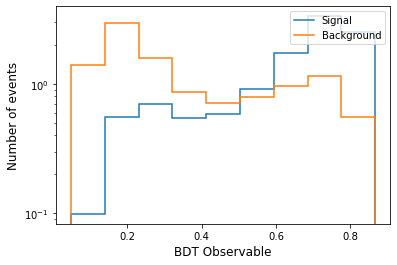

In [47]:
# To see better the separation power of the discriminant, we can also plot the normalized histograms

import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal', density=1)
hep.histplot(hist_bkg, bins, label='Background', density=1)

plt.xlabel('BDT Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

In [48]:
# The so called Asimov expected events (the exact number of events we would expect to observe if the 
# nominal mu=1 hypothesis is correct)

N_obs_Asimov = hist_sig + hist_bkg

print("The expected number of events in each bin of the discriminant: \n")
print(N_obs_Asimov)


The expected number of events in each bin of the discriminant: 

[ 81.44700434 173.27195032  94.42159246  51.71184839  42.99699869
  47.76060627  59.97951239  73.95018394  37.93186379]


<br>

In [49]:
# The polynomial part of the equation mentioned in Exercise 2 - no need to be bogged down with the details here
def poly_interp(alpha, varUp, varDown, varNom):
    
    # Calculate the co-efficients a_i 
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    

# The exponential part of the equation - for extrapolation
def exp_interp(alpha, varUp, varDown, varNom):
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


# Calculate the net yield, but now with systematic NP modif-iable histograms
def sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big):
    
    sigma_mu_binned = mu*hist_sig*fact_sig + hist_bkg*fact_big
                        
    return sigma_mu_binned


<br>

In [50]:
# Let's extract the systematic variations (start with only signal so you can follow the code)

NP_size = 100

arr_ratio_up_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]
arr_ratio_down_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    # Calculate the net weight variations for each of the systematics
    weight_up_sig = df_WW_Sig[systematic_name+'_up']*df_WW_Sig['mcWeight']
    weight_down_sig = df_WW_Sig[systematic_name+'_down']*df_WW_Sig['mcWeight']
    
    # Re-fill the histogram with new weights
    hist_sig_up, _ = np.histogram(obs_sig, bins, weights=weight_up_sig)
    hist_sig_down, _ = np.histogram(obs_sig, bins, weights=weight_down_sig)
    
    
    # Extract the up and down variations as a function of the discriminant histogram bins
    arr_ratio_up_sig[count] = 1.0+(hist_sig_up - hist_sig)
    arr_ratio_down_sig[count] = 1.0+(hist_sig_down - hist_sig)
    
arr_ratio_up_sig = jnp.array(arr_ratio_up_sig)
arr_ratio_down_sig = jnp.array(arr_ratio_down_sig)
    

<br>

In [51]:
# Let's do the same for bkg

arr_ratio_up_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]
arr_ratio_down_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    weight_up_bkg = df_WW_Bkg[systematic_name+'_up'].ravel()*df_WW_Bkg.mcWeight.ravel()
    weight_down_bkg = df_WW_Bkg[systematic_name+'_down'].ravel()*df_WW_Bkg.mcWeight.ravel()

    hist_bkg_up, _ = np.histogram(obs_bkg, bins, weights=weight_up_bkg)
    hist_bkg_down, _ = np.histogram(obs_bkg, bins, weights=weight_down_bkg)
    
    arr_ratio_up_bkg[count] = jnp.array(1.0+(hist_bkg_up - hist_bkg))
    arr_ratio_down_bkg[count] = jnp.array((1.0+(hist_bkg_down - hist_bkg)))
    
arr_ratio_up_bkg = jnp.array(arr_ratio_up_bkg)
arr_ratio_down_bkg = jnp.array(arr_ratio_down_bkg)


<br>

In [52]:
# Convert everything to JAX numpy arrays
N_obs_Asimov = jnp.array(N_obs_Asimov)

hist_sig = jnp.array(hist_sig)
hist_bkg = jnp.array(hist_bkg)

<br>

In [53]:
# Re-define the function to take into account systematic variations
def NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    mu = param_array[0]
    
    # Initialize the modification arrays
    fact_sig = jnp.ones_like(hist_sig)
    fact_bkg = jnp.ones_like(hist_sig)
    
    for n in range(1, param_array.shape[0]):
         
        # Find the modification factor for any value of parameter based on interpolation techniques
        fact_sig *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))   
        fact_bkg *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))      

    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_bkg)
    
    # Notice the last term coming from the log of subsidiary likelihood 
    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum() + jnp.sum(param_array[1:]**2)
        
    return llr



def NLL_minuit(param_array):
    
    return NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)



<br>

In [55]:
%%timeit -n1 -r1

tuple_syst = [0.0] * (101) 
tuple_syst[0] = 1.0 

tuple_syst = jnp.array(tuple_syst)

# Let's time the compilation step with Python control flow
NLL(tuple_syst, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)

1.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<br>

<br>

Now let's see how JAX makes the computation chart for this JIT-compiled function:

<br>

In [ ]:
# I have intentionally left the output blank because GitHub doesn't support scrollable outputs
# You can run this yourself and see the magnitude of the output

print(jax.make_jaxpr(jax.jit(NLL_minuit))(tuple_syst))

<br>

<br>

**Exercise**

<br>

In the lecture today, you saw how using JAX's primitive control flow operations like `lax.for_loop` can more efficiently work with JIT compilation.

<br>

Modify the test statistic function `NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)` to now use `lax.for_loop` instead of the regular for loop.

<br>

If you can also try to replace `jnp.where` wrapper of JAX with more primitive operations for a further efficiency boost. See https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow for more primitive operations.

<br>

In [57]:
# Define a new test statistic function with JAX control flow

def NLL_JCF(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    mu = param_array[0]
    
    def body_fun(n, carry):
        
        fact_s, fact_b = carry
        
        fact_s *= jax.lax.cond(jnp.abs(param_array[n])<=1.0, poly_interp, exp_interp, (param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))   
        fact_b *= jax.lax.cond(jnp.abs(param_array[n])<=1.0, poly_interp, exp_interp, (param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))      
        
        return (fact_s, fact_b)
    
    # Values are initialized as arrays of 1.0 - Can you guess why the shape is the same as hist_sig?
    fact_sig, fact_bkg = jax.lax.fori_loop(0, len(param_array), body_fun, (np.ones_like(hist_sig),np.ones_like(hist_sig)))
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_bkg)
    
    # Notice the last term coming from the log of subsidiary likelihood 
    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum() + jnp.sum(param_array[1:]**2)
        
    return llr

# Since we are using lax.cond, which accepts one argument in total we need to restructure the input parameter in the functions
def poly_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    # Calculate the co-efficients a_i 
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    
    
def exp_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


def NLL_minuit_JCF(param_array):
    
    return NLL_JCF(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)



<br>

In [58]:
# Now see how this function is treated by JAX - Does it look better?

print(jax.make_jaxpr(jax.jit(NLL_minuit_JCF))(tuple_syst))

{ lambda a:f32[100,9] b:f32[100,9] c:f32[100,9] d:f32[100,9] e:f32[9] f:f32[9] g:f32[9]
    h:f32[9] i:f32[9]; j:f32[21]. let
    k:f32[] = xla_call[
      call_jaxpr={ lambda ; l:f32[100,9] m:f32[100,9] n:f32[100,9] o:f32[100,9] p:f32[9]
          q:f32[9] r:f32[9] s:f32[9] t:f32[9] u:f32[21]. let
          v:bool[] = lt 0 0
          w:i32[] = add 0 21
          x:i32[] = select_n v 0 w
          y:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] x
          z:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] u y
          _:i32[] ba:f32[9] bb:f32[9] = scan[
            jaxpr={ lambda ; bc:f32[21] bd:f32[100,9] be:f32[100,9] bf:f32[100,9]
                bg:f32[100,9] bh:i32[] bi:f32[9] bj:f32[9]. let


<br>

Now let's time it - see if it is indeed better at compilation time compared to the old function.

<br>

In [59]:
%%timeit -n1 -r1

NLL_JCF(tuple_syst, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)

307 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<br>

There you go - the compilation + execution time was reduced by almost 6x when substituting Python for loop with `lax.fori_loop` for an input with 100 parameters! 

<br>

The more number of input parameters you add to this function, the more dramatic the speed-up can be!

<br>

And this is for a relatively simple example. With more complicated functions that require large memory the compilation speed-up can be even more dramatic!